<a href="https://colab.research.google.com/github/RamziRBM/lab-text-generation-shakespeare/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets.

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English.

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text.

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
import numpy as np
import re
from string import punctuation


Let's get the data!

In [2]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

data = re.sub(r"FROM fairest", "From fairest", data)
data = re.sub(r"[A-Z]+\.", "", data)
data = re.sub(r"[A-Z][A-Z\-]+\s", "", data)
data = re.sub(f"[{re.escape(punctuation)}]", "", data)
data = re.sub(r"\n\s*\n", "\n", data)
print (data)

corpus = data.lower().split("\n")


	
From fairest creatures we desire increase
That thereby beautys rose might never die
But as the riper should by time decease
His tender heir might bear his memory
But thou contracted to thine own bright eyes
Feedst thy lightst flame with selfsubstantial fuel
Making a famine where abundance lies
Thyself thy foe to thy sweet self too cruel
Thou that art now the worlds fresh ornament
And only herald to the gaudy spring
Within thine own bud buriest thy content
And tender churl makest waste in niggarding
  Pity the world or else this glutton be
  To eat the worlds due by the grave and thee
When forty winters shall beseige thy brow
And dig deep trenches in thy beautys field
Thy youths proud livery so gazed on now
Will be a tatterd weed of small worth held
Then being askd where all thy beauty lies
Where all the treasure of thy lusty days
To say within thine own deepsunken eyes
Were an alleating shame and thriftless praise
How much more praise deserved thy beautys use
If thou couldst answer T

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [3]:
# Your code here :
_tokenizer = Tokenizer(num_words=5000)
_tokenizer.fit_on_texts(corpus)


Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [4]:
# Your code here :
total_words = len(_tokenizer.word_index) + 1
total_words

3186

Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [5]:
# Your code here :
#!pip install tensorflow_transform

input_sequences = []

#tft.ngrams(tensor, (1,2), " ")

X = _tokenizer.texts_to_sequences(corpus)

Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [6]:
# Your code here :
max_sequence_len = max([len(x) for x in X])
input_sequences = np.array(pad_sequences(X, maxlen=max_sequence_len, padding='pre'))
print(max_sequence_len)
input_sequences

11


array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,  162,  210,  507],
       [   0,    0,    0, ...,  100,  163,  195],
       ...,
       [   0,  861,  138, ...,    8,    6,  187],
       [   0,    0,    0, ..., 3185,   14,   19],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=int32)

Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [7]:
# Your code here :
Predictors, Labels = input_sequences[:,:-1],input_sequences[:,-1]

One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors.

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [8]:
# Your code here :
Labels = ku.to_categorical(Labels, num_classes=total_words)
Labels.shape

(2158, 3186)

# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [9]:
model = Sequential([
    # Your code here :
    layers.Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len-1),
    layers.Bidirectional(LSTM(150, return_sequences=True)),
    layers.Dropout(0.2),
    layers.Bidirectional(LSTM(100)),
    layers.Dense(total_words//2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(total_words, activation="softmax"),

])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [10]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [12]:
# Train the model
print(Predictors.shape)

history = model.fit(Predictors, Labels, epochs=50, batch_size=10, verbose=1, validation_split=0.1)

(2158, 10)
Epoch 1/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.0103 - loss: 8.7629 - val_accuracy: 0.0370 - val_loss: 7.3596
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.0193 - loss: 6.7566 - val_accuracy: 0.0370 - val_loss: 7.5190
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.0178 - loss: 6.4767 - val_accuracy: 0.0370 - val_loss: 7.7760
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0225 - loss: 6.2670 - val_accuracy: 0.0370 - val_loss: 8.3725
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0129 - loss: 6.1300 - val_accuracy: 0.0370 - val_loss: 8.4675
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.0170 - loss: 6.0063 - val_accuracy: 0.0324 - val_loss: 8.9572
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0130 - loss: 5.9781 - val_accuracy: 0.0324 - val_loss: 8.9178
Epoch 8/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0175 - loss: 5.854

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

====  2nd model  =====


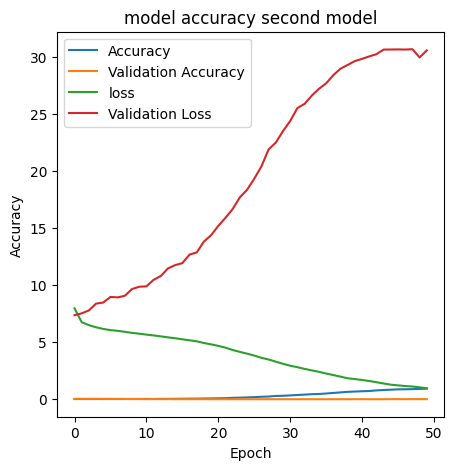

In [17]:
import matplotlib.pyplot as plt

def plot_accuracy(history, descr):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(5, 5))
  plt.plot(acc)
  plt.plot(val_acc)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title("model accuracy "+descr)
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
  plt.show()

#plot_accuracy(history, "first model")
print("====  2nd model  =====")
plot_accuracy(history, "second model")

# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [14]:
# Your code here :



```
# This is formatted as code
```

Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [15]:
def generate_text(model, start_string, num_generate):
  input_eval = [char_to_idx[s] for s in start_string]
  input_eval = np.array(input_eval).reshape((1, len(input_eval), 1))
  text_generated = []
  for i in range(num_generate):
    predictions = model.predict(input_eval)
    predicted_id = np.argmax(predictions[-1])
    input_eval = np.append(input_eval[:, 1:], [[predicted_id]], axis=1)
    text_generated.append(idx_to_char[predicted_id])
  return start_string + ''.join(text_generated)

Experiment with at least 3 different seed_text strings and see what happens!

In [16]:
# Your code here :